In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy.fft import fft, ifft

In [3]:
np.random.seed(0)

def fourier_eval(t, c, deriv=0):
    K = (len(c)-1)//2
    ks = jnp.arange(-K, K+1)
    E = jnp.exp(1j * ks[None, :] * t[:, None])
    c = (1j*ks[:, None])**deriv * c
    return E @ c


def fit_fourier(t, z, K=10):
    if len(z.shape) == 1:
        z = z[:, None]
    ks = np.arange(-K, K+1)
    E = np.exp(1j * ks[None, :] * t[:, None])        
    c = np.linalg.solve(np.conjugate(E.T) @ E, np.conjugate(E.T) @ z)
    return c

def loop_erased_rw():
    N = 100
    Nmax = 200
    Kmax = 15

    x,y = [0],[0]
    steps = [(0,1),(0,-1),(-1,0),(1,0)]


    for n in range(100000):
        step_idx = np.random.randint(0,4)
        dx,dy = steps[step_idx]
        xn = x[-1]+dx
        yn = y[-1]+dy

        intersects = [i for i in range(len(y)-1) if x[i]==xn and y[i]==yn]
        assert len(intersects) <= 1, "Something is wrong"

        if len(intersects) == 0:
            x.append(xn)
            y.append(yn)

        elif len(intersects) == 1:
            i = intersects[0]
            if (len(x) - i) >= Nmax:
                x = x[i:]
                y = y[i:]
                break
            else:
                x = x[:i+1]
                y = y[:i+1]        

    
    
    
    # Define numpy arrays
    z = np.array(x) + 1j*np.array(y)
    dz = z - jnp.roll(z, 1)
    
    # If clock-wise, change direction.
    dz0 = dz[1]/jnp.abs(dz[1])
    z0 = (z[0]+z[1])/2
    dz0_orth = 1j*dz0
    dot = lambda x,y: jnp.real(x*y.conj())
    count = 0
    
    #plt.figure()
    for i in range(1,len(z)-1):
        a = z[i]-z0
        b = z[i+1] - z0
        if (dot(a, dz0) * dot(b, dz0) < 0) and (dot((a+b)/2, dz0_orth) >= 0): 
            count += 1
            #plt.scatter(((a+b)/2+z0).real, ((a+b)/2+z0).imag)
    if count % 2 == 0:
        z = z[::-1]
    #print(f"Changed direction for loop. count={count}")
    #plt.plot(z.real, z.imag)
    #plt.quiver(z0.real, z0.imag, dz0.real, dz0.imag)
    
    
    # Compute arc_lengths
    arclen = np.abs(dz)
    totlen = jnp.sum(arclen)
    z_mean = jnp.sum(dz*arclen)/totlen/2
    
    z = z - z_mean
    Rmax = jnp.max(jnp.abs(z))
    z = z/Rmax
    t = 2*np.pi * jnp.cumsum(arclen)/totlen

    # Fit
    c = fit_fourier(t, z, K=Kmax)
    
    # Reparameterize with higher resolution.
    for i in range(0):
        Nref = 1000
        t = jnp.linspace(0, 2*np.pi, Nref+1)[1:] + np.random.rand()
        z = fourier_eval(t, c, deriv=0)
        dz = fourier_eval(t, c, deriv=1)
        t = jnp.abs(dz)#(dxy[:, 0]**2 + dxy[:, 1]**2)**0.5
        t = jnp.cumsum(t)
        t = t / t[-1] * 2*np.pi
        c = fit_fourier(t, z, K=Kmax)
    
    return c

M = 9
clist = []
for i in range(M):
    #print(f"Loop {i}")
    clist.append(loop_erased_rw())
  

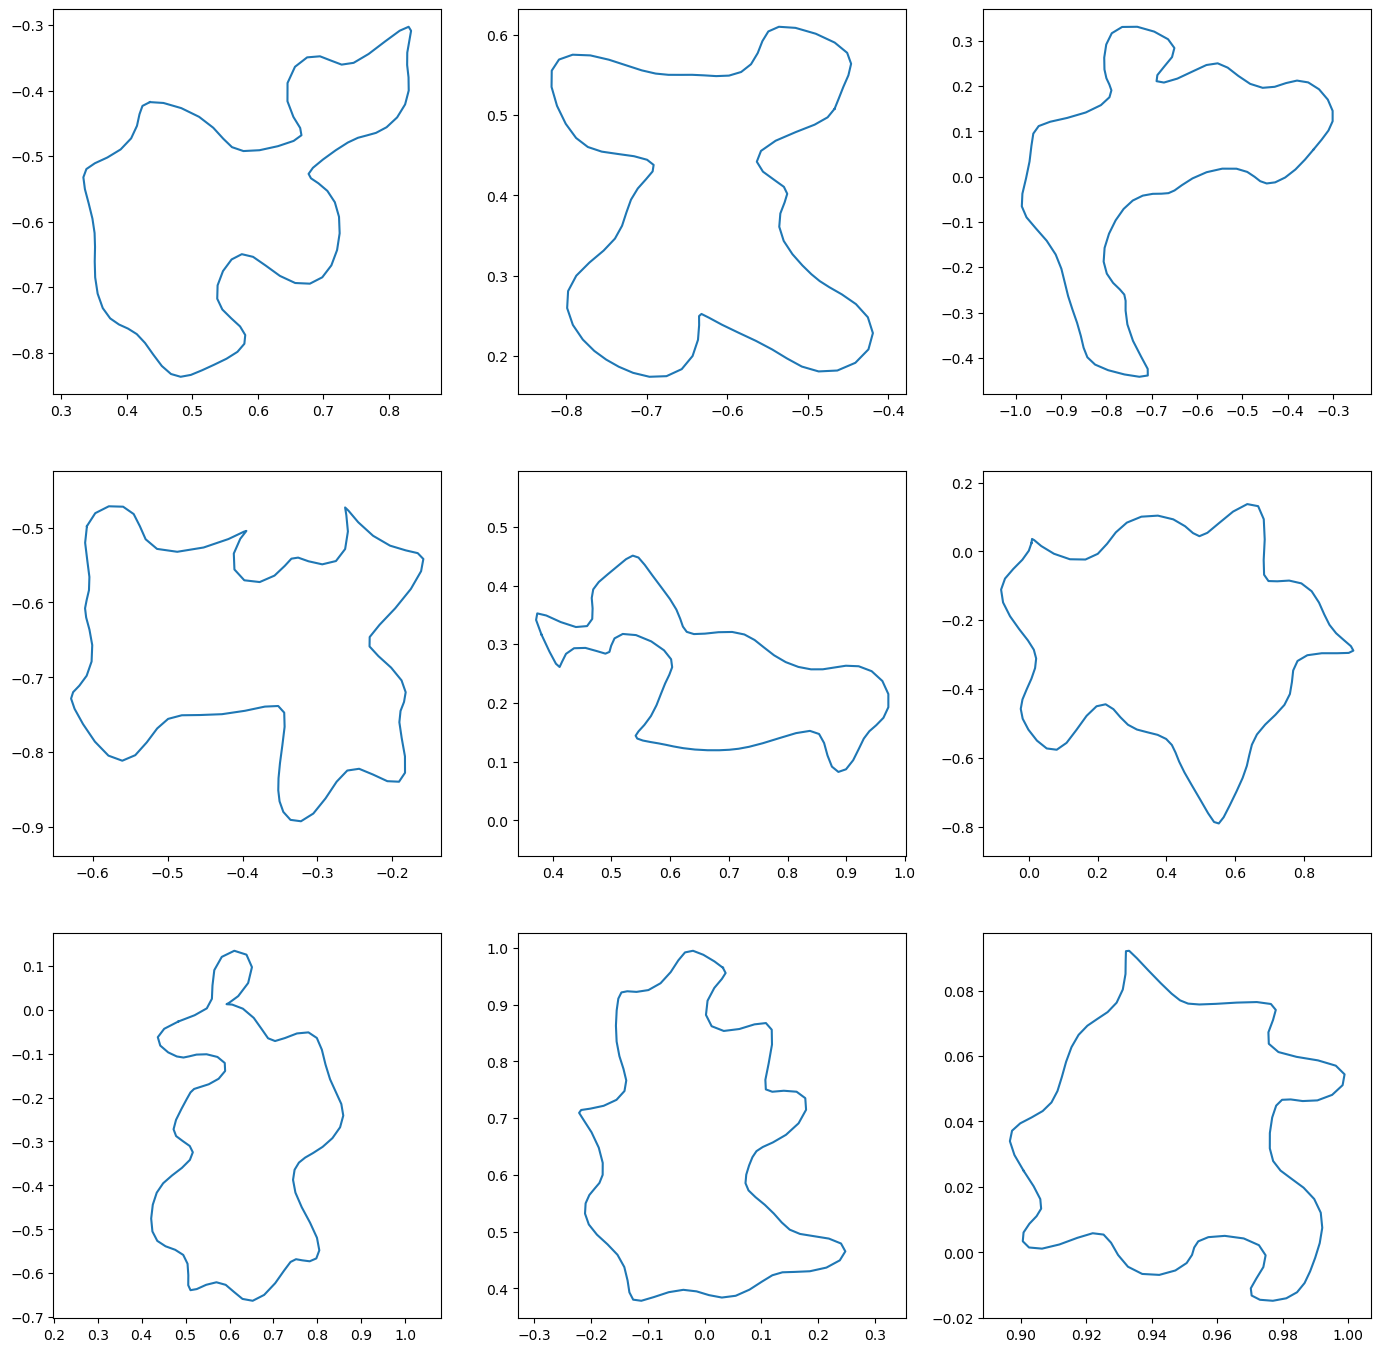

In [4]:
  
plt.figure(figsize=(17,17))
pts = []

Msqrt = int(np.floor(np.sqrt(M)))
for i in range(Msqrt*Msqrt):
    t = jnp.linspace(0, 2*np.pi, 100) 
    c = clist[i]
    z = fourier_eval(t, c)
    dz = fourier_eval(t, c, 1)
    
    plt.figure(1)
    plt.subplot(Msqrt,Msqrt,i+1)
    plt.plot(z.real, z.imag)
    plt.axis("equal")


(-0.10675066411495208,
 0.10379096567630768,
 -0.11636116467416287,
 0.09859882406890393)

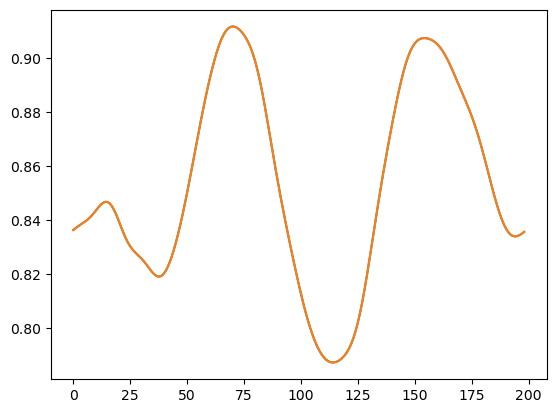

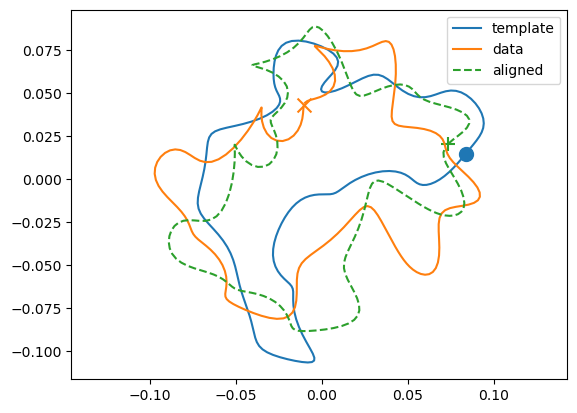

In [ ]:
def rotate(z, angle):
    return np.exp(1j*angle)*z

def rotate_fourier(c, angle, shift):
    K = (len(c)-1)//2
    ks = jnp.arange(-K, K+1)
    return np.exp(1j * (angle + ks[:,None]*shift)) * c

def error(z1, z2):
    return (jnp.mean(jnp.abs(z1-z2)**2))**0.5


def normalize(z):
    z = z - jnp.mean(z)
    return z / jnp.sum(jnp.abs(z)**2)**0.5

def conv(x1, x2):
    M = len(x1)
    #return jnp.array([jnp.sum(x1*jnp.roll(x2[::-1,:], m, axis=0)) for m in range(M)])
    return jnp.array([jnp.sum(jnp.roll(x1, -(m+1))*x2[::-1, :]) for m in range(M)])

def corr(x1, x2):
    M = len(x1)
    return jnp.array([jnp.sum(x1.conj()*jnp.roll(x2, -m, axis=0)) for m in range(M)])

def flip(x):
    return jnp.flip(x, axis=0)  

def corr_fft(x1, x2):
    return flip(ifft(fft(x1.conj().T) * fft(flip(x2).T)).T)
    #return ifft(fft(x1.conj().T).conj() * fft(x2.T).conj()).T
    

def conv_fft(x1, x2):
    x1_fft = fft(x1.T)
    x2_fft = fft(x2.T)
    return ifft(x1_fft * x2_fft).T

def align(z0, z1):
    #ab = conv_fft(z0, z1.conj())
    ab = corr_fft(z0, z1)
    m = np.argmax(jnp.abs(ab))
    theta = jnp.arctan2(ab[m].imag, ab[m].real)
    
    #err = 
    # Normalize 
    #plt.plot(jnp.abs(corr(z0, z1)))
    #plt.plot(jnp.abs(corr_fft(z0, z1)))
    return theta, m


#theta_true = 0.25*np.pi
#xy_rot = rotate(xy, theta_true)
#xy_rot = fourier_eval(t, clist[0]+np.random.randn(*clist[0].shape)*0.02)
#c2 = rotate_fourier(c2, theta_true, np.pi)
#fourier_eval(t, c2)
#c21 = rotate_fourier(c2, angle=theta, shift=2*np.pi*m/len(z1))
#z21 = jnp.roll(rotate(z2, theta), m)
#z1 = fourier_eval(t, c1)
#z2 = fourier_eval(t, c2)
#z21 = fourier_eval(t, c21)

Nref = 200
t = jnp.linspace(0, 2*np.pi, Nref)[:-1]
c1 = clist[2]
c2 = clist[3]
z1 = normalize(fourier_eval(t, c1))
z2 = jnp.roll(normalize(rotate(fourier_eval(t, c2),0.2*np.pi)), 40)#+np.random.randn(*z1.shape)*0.0
theta, m = align(z2, z1)
z21 = jnp.roll(rotate(z2, theta), m)

plt.figure()
plt.plot(z1.real, z1.imag, label="template")
plt.scatter(z1[0].real, z1[0].imag, s=100)
plt.plot(z2.real, z2.imag, label="data")
plt.scatter(z2[0].real, z2[0].imag, s=100, marker='x')
plt.plot(z21.real, z21.imag, '--', label="aligned")
plt.scatter(z21[0].real, z21[0].imag, s=100, marker='+')
plt.legend()
plt.axis("equal")

#plt.figure()
#plt.plot(z1.real, z1.imag)
#plt.scatter(z1[m].real, z1[m].imag)
#plt.plot(z2.real, z2.imag, '--')
#plt.scatter(z2[0].real, z2[0].imag)
#plt.plot(z21.real, z21.imag,'--')
#plt.axis("equal")


